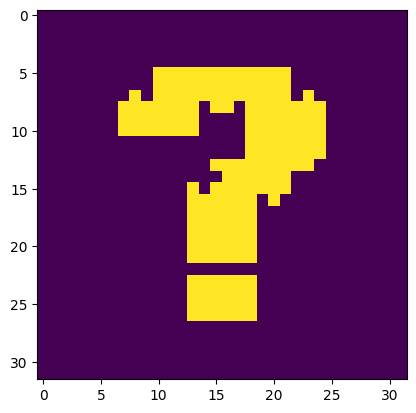

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

'''
First load in the substrate and visualise it
'''

substrate = np.load('data/toy_examples/question_mark_substrate.npy')

plt.imshow(substrate)

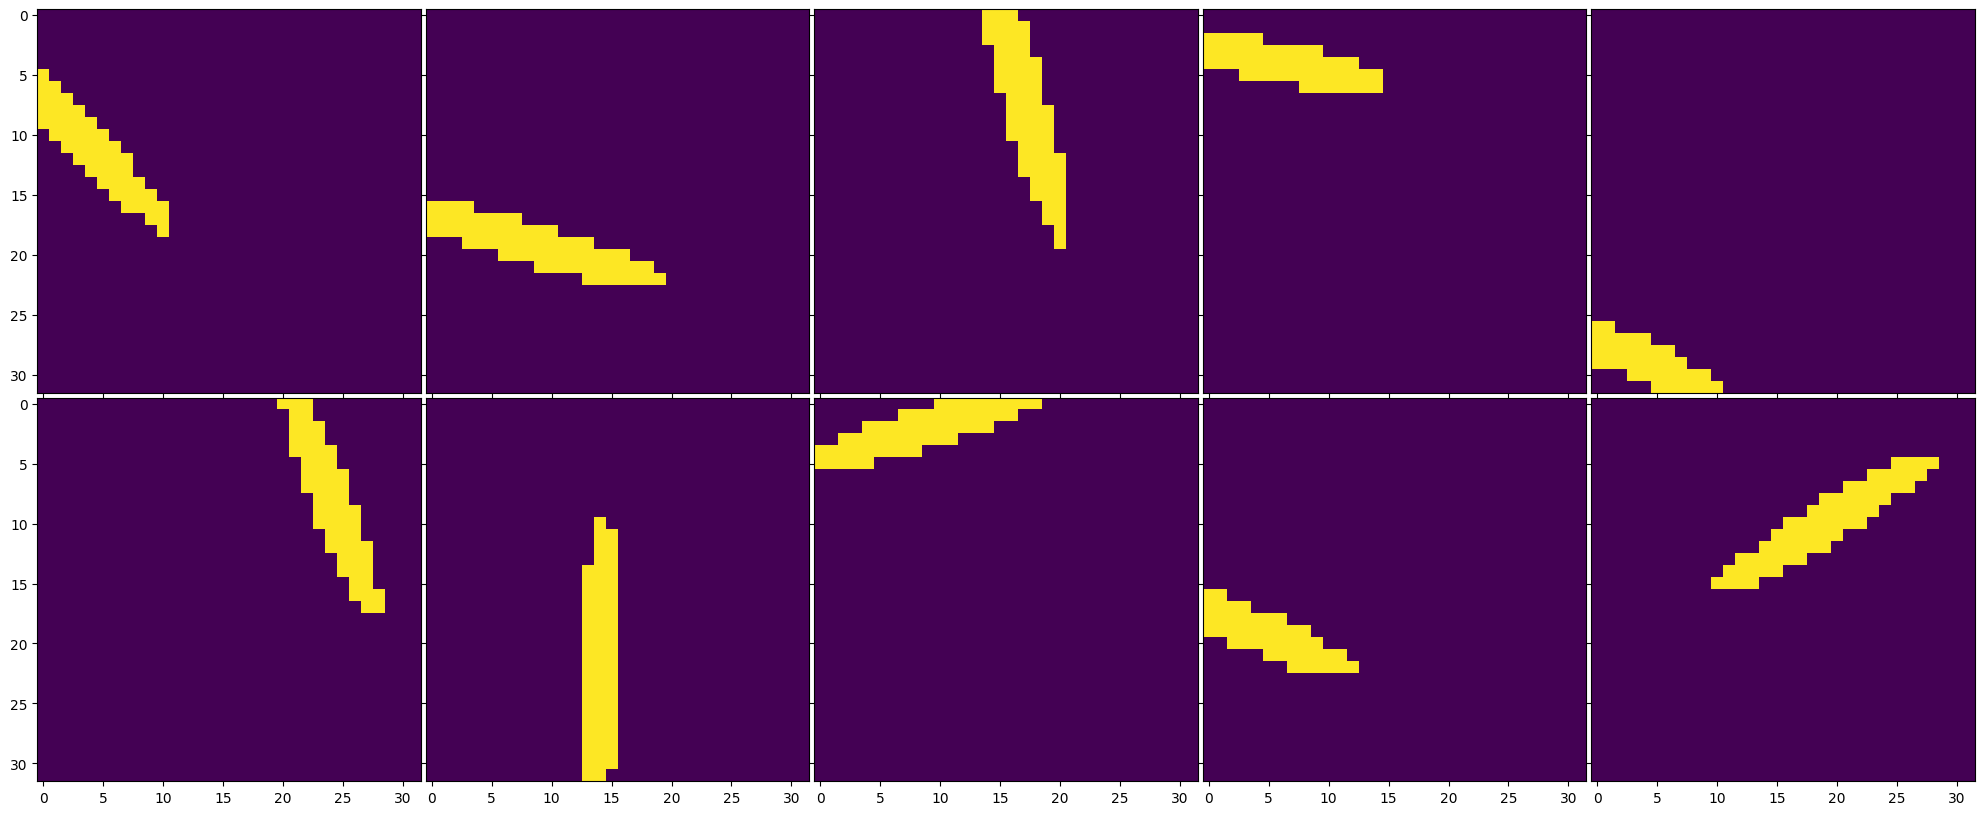

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid

'''
Load in 1000 32x32 lesions, that are basically just ellipsoids
'''

lesions = np.load('data/toy_examples/1000_lesions.npy')

# Let's visualise a few
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 5),
                 axes_pad=0.05,
                 share_all=True
                 )

for i in range(10):
    grid[i].imshow(lesions[i])

(array([606.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 394.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

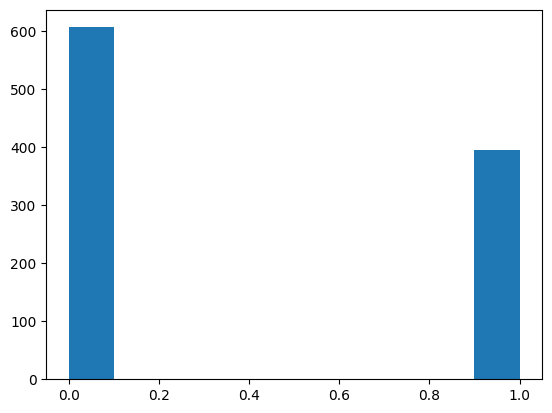

In [3]:
# LET'S SIMULATE SOME BINARY SCORES

# Threshold after which there is deficit
BINARY_THRESHOLD = 0.05

deficit_scores = [0 for i in range(len(lesions))]
positive_indices = []
for i in range(len(lesions)):
    overlap = lesions[i] * substrate
    counts = np.count_nonzero(overlap)
    voxels_gt = np.sum(substrate)
    ratio_lesion = counts / voxels_gt

    if ratio_lesion > BINARY_THRESHOLD:
        deficit_scores[i] = 1 
    else:
        deficit_scores[i] = 0
                
deficit_scores = np.array(deficit_scores)
plt.hist(deficit_scores)

In [4]:
from sklearn.model_selection import train_test_split

# WE NEED TO ADD ONE EXTRA CHANNEL AS DL MODELS EXPECT A COLOUR CHANNEL
lesions = np.expand_dims(lesions, axis=1)

# FIRST SPLIT INTO 90/10
train_data, vc_data, train_labels, vc_labels = train_test_split(lesions,
                                                                deficit_scores,
                                                                test_size=0.1)

# THEN SPLIT THE REMAINING 10% INTO VALIDATION AND CALIBRATION - 50/50
val_data, cal_data, val_labels, cal_labels = train_test_split(vc_data,
                                                              vc_labels,
                                                              test_size=0.5)

train_data.shape, val_data.shape, cal_data.shape

((900, 1, 32, 32), (50, 1, 32, 32), (50, 1, 32, 32))

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# class DeficitDataset(Dataset):

#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         img = self.data[index]
#         return img, np.expand_dims(self.labels[index], axis=0)
    
    
class DeficitDataset(Dataset):
    """
    Dataset that holds tensors already on GPU.
    Works perfectly with DataLoader!
    """
    def __init__(self, data, labels, device):
        # Convert to tensors and move to GPU
        if isinstance(data, np.ndarray):
            self.data = torch.tensor(data, dtype=torch.float32, device=device)
        else:
            self.data = data.to(device)
            
        print(self.data.shape)
            
        if isinstance(labels, np.ndarray):
            self.labels = torch.tensor(labels, dtype=torch.float32, device=device)
        else:
            self.labels = labels.to(device)
        
        if self.labels.dim() == 1:
            self.labels = self.labels.unsqueeze(1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        """
        DataLoader will call this method.
        Since data is already on GPU, this just returns GPU tensors!
        """
        return self.data[index], self.labels[index]

batch_size = 64

# CREATE DATA LOADERS
# TRAINING
dataset = DeficitDataset(data=train_data, labels=train_labels, device=device)
train_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=False)

# VALIDATION
val_dataset = DeficitDataset(data=val_data, labels=val_labels, device=device)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=False)

# CALIBRATION
# cal_dataset = DeficitDataset(data=cal_data, labels=cal_labels)
# cal_loader = DataLoader(cal_dataset, batch_size=batch_size, drop_last=False,
#                                             shuffle=True, num_workers=10, pin_memory=True)


Using device: cuda:0
torch.Size([900, 1, 32, 32])
torch.Size([50, 1, 32, 32])


In [498]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


class SpatialSubstrate(nn.Module):
    def __init__(self, substrate_shape, latent_dim=32, base_size=4, kl_weight=1e-2, 
                 conditional=False, conditional_dropout=0.1):
        """
        Args:
            substrate_shape: tuple (C, H, W) - shape of substrate to generate
            latent_dim: dimensionality of latent code
            base_size: starting spatial size for decoder (will upsample to H, W)
            kl_weight: weight for KL divergence term
            conditional: if True, condition substrate generation on input x
            conditional_dropout: probability of dropping conditioning during training (for CFG)
        """
        super().__init__()
        self.substrate_shape = substrate_shape
        self.latent_dim = latent_dim
        self.base_size = base_size
        self.kl_weight = kl_weight
        self.conditional = conditional
        self.conditional_dropout = conditional_dropout
        
        C, H, W = substrate_shape
        self.C, self.H, self.W = C, H, W
        
        # Always have base latent parameters (unconditional part)
        self.latent_mu = nn.Parameter(torch.randn(latent_dim) * 0.01)
        self.latent_log_sigma = nn.Parameter(torch.zeros(latent_dim) - 1.0)
        
        if conditional:
            # Encoder extracts conditioning features from x
            self.encoder = nn.Sequential(
                nn.Conv2d(C, 32, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten()
            )
            
            # Direct linear mapping for conditioning (simpler than bottleneck)
            self.condition_mu = nn.Linear(128, latent_dim)
            self.condition_log_sigma = nn.Linear(128, latent_dim)
        
        # Decoder (same for both conditional and unconditional)
        n_upsample = int(np.log2(H / base_size))
        base_channels = 128
        self.fc = nn.Linear(latent_dim, base_channels * base_size * base_size)
        
        layers = []
        in_channels = base_channels
        for i in range(n_upsample):
            out_channels = base_channels // (2 ** (i + 1))
            out_channels = max(out_channels, 16)
            
            layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, 
                                 stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            ])
            in_channels = out_channels
        
        layers.append(
            nn.Conv2d(in_channels, C, kernel_size=3, padding=1)
        )
        
        self.decoder = nn.Sequential(*layers)
        
    def get_conditional_params(self, x, use_conditioning=True):
        """
        Get μ and σ, optionally conditioned on input x.
        
        Args:
            x: [B, C, H, W] or None
            use_conditioning: if False, return unconditional params even if model is conditional
            
        Returns:
            mu: [latent_dim] if unconditional, [B, latent_dim] if conditional
            log_sigma: [latent_dim] if unconditional, [B, latent_dim] if conditional
        """
        if not self.conditional or x is None or not use_conditioning:
            # Return base parameters (unconditional)
            if x is not None and x.dim() == 4:
                # Expand for batch
                B = x.shape[0]
                return self.latent_mu.unsqueeze(0).expand(B, -1), \
                       self.latent_log_sigma.unsqueeze(0).expand(B, -1)
            return self.latent_mu, self.latent_log_sigma
        
        # Extract conditioning features from x [B, C, H, W]
        features = self.encoder(x)  # [B, 128]
        
        # Get deltas from conditioning networks
        mu_delta = self.condition_mu(features)  # [B, latent_dim]
        log_sigma_delta = self.condition_log_sigma(features)  # [B, latent_dim]
        
        # Base parameters + conditioning deltas
        mu = self.latent_mu.unsqueeze(0) + mu_delta  # [B, latent_dim]
        log_sigma = self.latent_log_sigma.unsqueeze(0) + log_sigma_delta  # [B, latent_dim]
        
        return mu, log_sigma
    
    def reparameterize(self, mu, log_sigma):
        """Reparameterization trick for sampling"""
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(sigma)
        return mu + sigma * eps
    
    def decode(self, z):
        """Decode latent code to substrate. z can be [latent_dim] or [B, latent_dim]"""
        if z.dim() == 1:
            z = z.unsqueeze(0)
        
        B = z.shape[0]
        h = self.fc(z)  # [B, channels * base_size * base_size]
        h = h.view(B, -1, self.base_size, self.base_size)
        substrate = self.decoder(h)  # [B, C, H, W]
        
        # Ensure correct spatial size
        if substrate.shape[-2:] != (self.H, self.W):
            substrate = F.interpolate(substrate, size=(self.H, self.W), 
                                     mode='bilinear', align_corners=False)
        
        return substrate
    
    def sample_substrates(self, n_samples=1, x=None):
        """
        Sample substrates. 
        - Unconditional: samples n_samples from learned prior N(latent_mu, latent_log_sigma)
        - Conditional: samples one substrate per x (ignores n_samples parameter)

        Args:
            n_samples: number of samples (only used for unconditional)
            x: [B, C, H, W] for conditional, None for unconditional

        Returns:
            [n_samples, C, H, W] for unconditional
            [B, C, H, W] for conditional (one sample per input)
        """
        with torch.no_grad():
            if not self.conditional or x is None:
                # Unconditional: sample n_samples from learned base distribution
                mu = self.latent_mu.unsqueeze(0).expand(n_samples, -1)
                log_sigma = self.latent_log_sigma.unsqueeze(0).expand(n_samples, -1)
                z = self.reparameterize(mu, log_sigma)
                return self.decode(z)  # [n_samples, C, H, W]
            else:
                # Conditional: one sample per x
                mu, log_sigma = self.get_conditional_params(x)  # [B, latent_dim]
                z = self.reparameterize(mu, log_sigma)  # [B, latent_dim]
                return self.decode(z)  # [B, C, H, W]
    
    def sample_substrates_with_guidance(self, x, guidance_scale=1.0):
        """
        Sample with classifier-free guidance.
        
        Args:
            x: [B, C, H, W] input
            guidance_scale: 
                0.0 → purely unconditional (base only)
                1.0 → purely conditional (base + delta)
                > 1.0 → amplified conditioning
        
        Returns:
            [B, C, H, W] substrates
        """
        with torch.no_grad():
            if not self.conditional:
                raise ValueError("Guidance only available for conditional models")
            
            # Get conditional params (base + delta)
            mu_cond, log_sigma_cond = self.get_conditional_params(x, use_conditioning=True)
            
            # Get unconditional params (just base)
            mu_uncond, log_sigma_uncond = self.get_conditional_params(x, use_conditioning=False)
            
            # Interpolate: mu_guided = mu_uncond + w * (mu_cond - mu_uncond)
            mu = mu_uncond + guidance_scale * (mu_cond - mu_uncond)
            log_sigma = log_sigma_uncond + guidance_scale * (log_sigma_cond - log_sigma_uncond)
            
            z = self.reparameterize(mu, log_sigma)
            return self.decode(z)
    
    def kl_divergence(self, mu=None, log_sigma=None):
        """KL divergence between posterior q(z|x) and prior p(z) = N(0, I)"""
        if mu is None:
            mu = self.latent_mu
        if log_sigma is None:
            log_sigma = self.latent_log_sigma
            
        sigma = torch.exp(log_sigma)
        kl = 0.5 * torch.sum(mu**2 + sigma**2 - 2*log_sigma - 1, dim=-1)
        return kl.sum()  # Sum over batch if present
    
    def forward(self, x, y, free_bits=0.5, **_):
        """
        Forward pass matching your existing signature.

        Args:
            x: input tensor [B, C, H, W]
            y: target tensor [B] or [B, 1]
            free_bits: minimum KL per latent dimension (prevents collapse)

        Returns:
            dict with 'loss' and 'substrate_logits'
        """
        B = x.shape[0]

        # Randomly drop conditioning during training (classifier-free guidance)
        use_conditioning = True
        if self.conditional and self.training and torch.rand(1).item() < self.conditional_dropout:
            use_conditioning = False

        # Get parameters (base + deltas if conditional and not dropped)
        mu, log_sigma = self.get_conditional_params(x, use_conditioning=use_conditioning)

        if not self.conditional or not use_conditioning:
            # Unconditional: single substrate for entire batch
            z = self.reparameterize(mu, log_sigma)
            substrate_logits = self.decode(z)  # [1, C, H, W]
            substrate_logits = substrate_logits.expand(B, -1, -1, -1)

            # KL per dimension: [latent_dim]
            sigma = torch.exp(log_sigma)
            kl_per_dim = 0.5 * (mu**2 + sigma**2 - 2*log_sigma - 1)

            # Apply free bits
            kl_constrained = torch.max(kl_per_dim - free_bits, torch.zeros_like(kl_per_dim))
            kl = kl_constrained.sum()

        else:
            # Conditional: one substrate per sample
            z = self.reparameterize(mu, log_sigma)  # [B, latent_dim]
            substrate_logits = self.decode(z)  # [B, C, H, W]

            # KL posterior per dimension: [B, latent_dim]
            sigma = torch.exp(log_sigma)
            kl_per_dim_posterior = 0.5 * (mu**2 + sigma**2 - 2*log_sigma - 1)

            # Apply free bits and average over batch
            kl_constrained_posterior = torch.max(kl_per_dim_posterior - free_bits, 
                                                torch.zeros_like(kl_per_dim_posterior))
            kl_posterior = kl_constrained_posterior.sum(dim=-1).mean()

            # KL base per dimension: [latent_dim]
            sigma_base = torch.exp(self.latent_log_sigma)
            kl_per_dim_base = 0.5 * (self.latent_mu**2 + sigma_base**2 - 2*self.latent_log_sigma - 1)

            # Apply free bits
            kl_constrained_base = torch.max(kl_per_dim_base - free_bits, 
                                            torch.zeros_like(kl_per_dim_base))
            kl_base = kl_constrained_base.sum()

            # Total KL
            kl = kl_posterior + kl_base

        # Your existing overlap computation
        overlap = x * substrate_logits
        logits_global = torch.mean(overlap, dim=(-3, -2, -1)).view(-1, 1)

        # BCE loss
        substrate_loss = F.binary_cross_entropy_with_logits(logits_global, y.float().view(-1, 1)).mean()

        # Total loss
        loss = substrate_loss + self.kl_weight * kl

        return {
            "loss": loss,
            "substrate_loss": substrate_loss,
            "kl_loss": kl,
            "substrate_logits": substrate_logits,
        }

In [499]:
import torch
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

substrate_shape = (1, 32, 32)
model = SpatialSubstrate(substrate_shape, latent_dim=32, kl_weight=1, conditional=True, conditional_dropout=0.5).to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    
scheduler = CosineAnnealingLR(optimizer, T_max=3000, eta_min=1e-6)

Epoch 0: train=85.0051, val={'loss': 4.929710388183594, 'substrate_loss': 0.6931199431419373, 'kl_loss': 4.236590385437012}
torch.Size([50, 1, 32, 32])


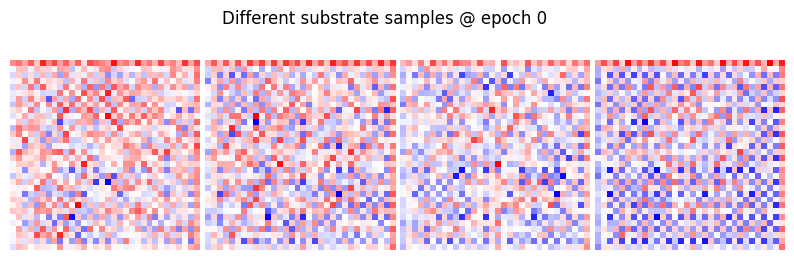

Epoch 50: train=3.6832, val={'loss': 0.6302650570869446, 'substrate_loss': 0.5792414546012878, 'kl_loss': 0.05102360248565674}
Epoch 100: train=0.3815, val={'loss': 0.45004308223724365, 'substrate_loss': 0.44520437717437744, 'kl_loss': 0.004838705062866211}
Epoch 150: train=0.3120, val={'loss': 0.34166473150253296, 'substrate_loss': 0.3384157121181488, 'kl_loss': 0.003249018220230937}
Epoch 200: train=0.2407, val={'loss': 0.3124275803565979, 'substrate_loss': 0.3114524483680725, 'kl_loss': 0.0009751224424690008}
torch.Size([50, 1, 32, 32])


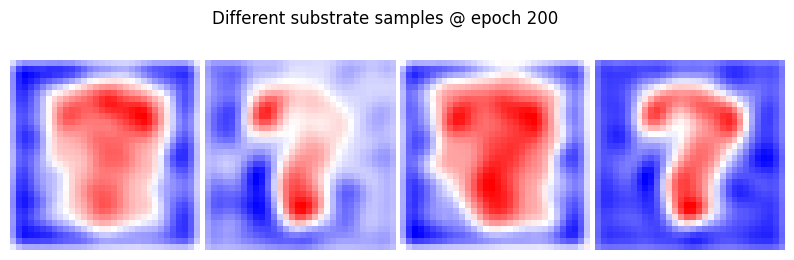

Epoch 250: train=0.2233, val={'loss': 0.2647876739501953, 'substrate_loss': 0.26428502798080444, 'kl_loss': 0.000502655515447259}
Epoch 300: train=0.1825, val={'loss': 0.2345978021621704, 'substrate_loss': 0.2325247973203659, 'kl_loss': 0.0020730113610625267}
Epoch 350: train=0.1353, val={'loss': 0.24920979142189026, 'substrate_loss': 0.24680671095848083, 'kl_loss': 0.0024030732456594706}
Epoch 400: train=0.1277, val={'loss': 0.2465188354253769, 'substrate_loss': 0.2460165023803711, 'kl_loss': 0.0005023288540542126}
torch.Size([50, 1, 32, 32])


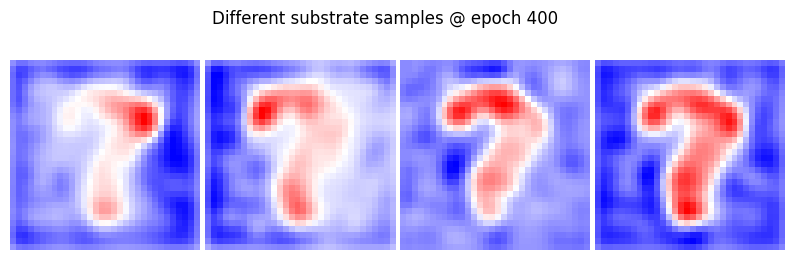

Epoch 450: train=0.1547, val={'loss': 0.2538469135761261, 'substrate_loss': 0.25318560004234314, 'kl_loss': 0.0006613087607547641}
Epoch 500: train=0.1161, val={'loss': 0.22048573195934296, 'substrate_loss': 0.21962261199951172, 'kl_loss': 0.0008631181553937495}
Epoch 550: train=0.0946, val={'loss': 0.17005398869514465, 'substrate_loss': 0.1696791797876358, 'kl_loss': 0.0003748082963284105}
Epoch 600: train=0.1024, val={'loss': 0.16611696779727936, 'substrate_loss': 0.1651587188243866, 'kl_loss': 0.000958242395427078}
torch.Size([50, 1, 32, 32])


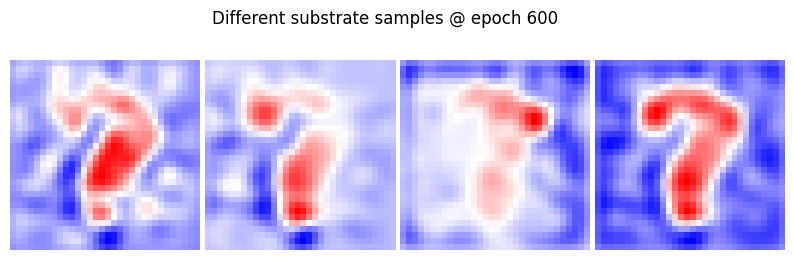

Epoch 650: train=0.0812, val={'loss': 0.150605708360672, 'substrate_loss': 0.15060167014598846, 'kl_loss': 4.038810857309727e-06}
Epoch 700: train=0.0753, val={'loss': 0.13060727715492249, 'substrate_loss': 0.1301594376564026, 'kl_loss': 0.00044783353223465383}
Epoch 750: train=0.0710, val={'loss': 0.1085597574710846, 'substrate_loss': 0.10837022215127945, 'kl_loss': 0.00018953561084344983}
Epoch 800: train=0.0595, val={'loss': 0.20715545117855072, 'substrate_loss': 0.20316630601882935, 'kl_loss': 0.003989143297076225}
torch.Size([50, 1, 32, 32])


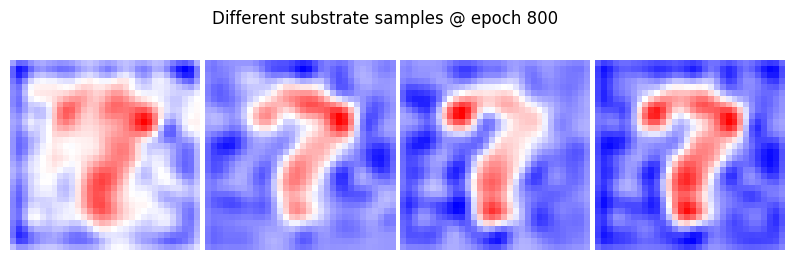

Epoch 850: train=0.0480, val={'loss': 0.15356892347335815, 'substrate_loss': 0.1493099480867386, 'kl_loss': 0.0042589688673615456}
Epoch 900: train=0.0519, val={'loss': 0.10408645123243332, 'substrate_loss': 0.10228696465492249, 'kl_loss': 0.0017994832014665008}
Epoch 950: train=0.0495, val={'loss': 0.07713741809129715, 'substrate_loss': 0.07145492732524872, 'kl_loss': 0.005682492163032293}
Epoch 1000: train=0.0553, val={'loss': 0.09621765464544296, 'substrate_loss': 0.09344051778316498, 'kl_loss': 0.0027771377936005592}
torch.Size([50, 1, 32, 32])


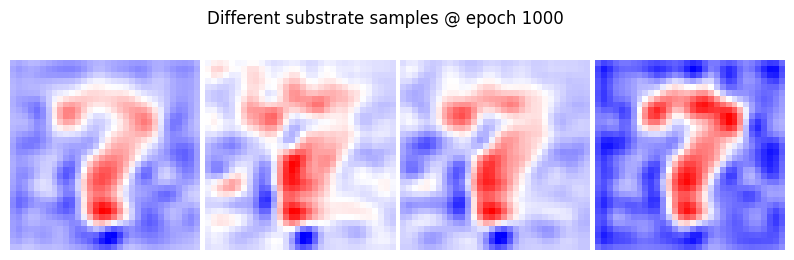

Epoch 1050: train=0.0396, val={'loss': 0.1460907906293869, 'substrate_loss': 0.14077746868133545, 'kl_loss': 0.005313317757099867}
Epoch 1100: train=0.0384, val={'loss': 0.17786279320716858, 'substrate_loss': 0.16863784193992615, 'kl_loss': 0.009224951267242432}
Epoch 1150: train=0.0647, val={'loss': 0.1348739117383957, 'substrate_loss': 0.12964530289173126, 'kl_loss': 0.005228602793067694}
Epoch 1200: train=0.0349, val={'loss': 0.16725695133209229, 'substrate_loss': 0.16170577704906464, 'kl_loss': 0.005551180802285671}
torch.Size([50, 1, 32, 32])


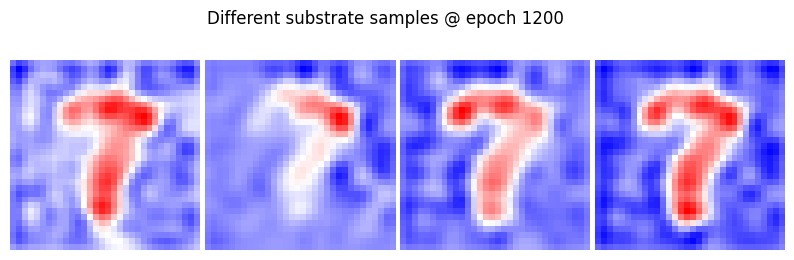

Epoch 1250: train=0.0426, val={'loss': 0.05925077199935913, 'substrate_loss': 0.05038830637931824, 'kl_loss': 0.008862466551363468}
Epoch 1300: train=0.0421, val={'loss': 0.15711644291877747, 'substrate_loss': 0.14927664399147034, 'kl_loss': 0.007839800789952278}
Epoch 1350: train=0.0256, val={'loss': 0.1409149169921875, 'substrate_loss': 0.1304796040058136, 'kl_loss': 0.010435309261083603}
Epoch 1400: train=0.0401, val={'loss': 0.18696357309818268, 'substrate_loss': 0.17755980789661407, 'kl_loss': 0.00940376240760088}
torch.Size([50, 1, 32, 32])


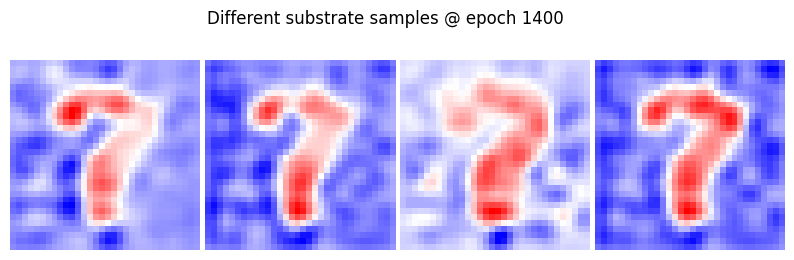

Epoch 1450: train=0.0314, val={'loss': 0.1693134605884552, 'substrate_loss': 0.15913830697536469, 'kl_loss': 0.010175156407058239}
Epoch 1500: train=0.0332, val={'loss': 0.09652860462665558, 'substrate_loss': 0.08580984175205231, 'kl_loss': 0.01071876473724842}
Epoch 1550: train=0.0339, val={'loss': 0.09944596141576767, 'substrate_loss': 0.08406807482242584, 'kl_loss': 0.015377883799374104}
Epoch 1600: train=0.0212, val={'loss': 0.08865262567996979, 'substrate_loss': 0.07695093750953674, 'kl_loss': 0.011701690964400768}
torch.Size([50, 1, 32, 32])


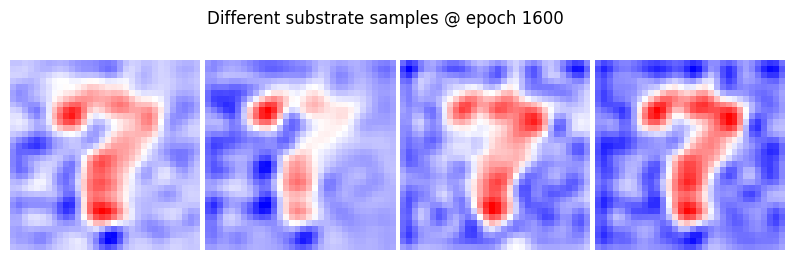

Epoch 1650: train=0.0351, val={'loss': 0.18686112761497498, 'substrate_loss': 0.17638106644153595, 'kl_loss': 0.010480060242116451}
Epoch 1700: train=0.0338, val={'loss': 0.17031937837600708, 'substrate_loss': 0.15096962451934814, 'kl_loss': 0.019349757581949234}
Epoch 1750: train=0.0229, val={'loss': 0.1416848748922348, 'substrate_loss': 0.11499688029289246, 'kl_loss': 0.0266879890114069}
Epoch 1800: train=0.0312, val={'loss': 0.20679253339767456, 'substrate_loss': 0.17909255623817444, 'kl_loss': 0.027699973434209824}
torch.Size([50, 1, 32, 32])


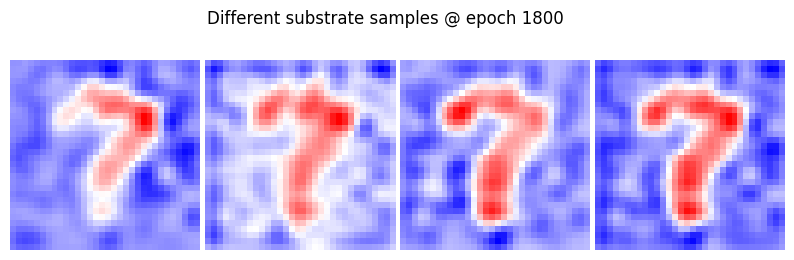

Epoch 1850: train=0.0183, val={'loss': 0.12024398148059845, 'substrate_loss': 0.0976116731762886, 'kl_loss': 0.022632308304309845}
Epoch 1900: train=0.0315, val={'loss': 0.1680735945701599, 'substrate_loss': 0.14496707916259766, 'kl_loss': 0.023106511682271957}
Epoch 1950: train=0.0246, val={'loss': 0.19328901171684265, 'substrate_loss': 0.16612005233764648, 'kl_loss': 0.027168963104486465}
Epoch 2000: train=0.0093, val={'loss': 0.1003318727016449, 'substrate_loss': 0.07080123573541641, 'kl_loss': 0.029530638828873634}
torch.Size([50, 1, 32, 32])


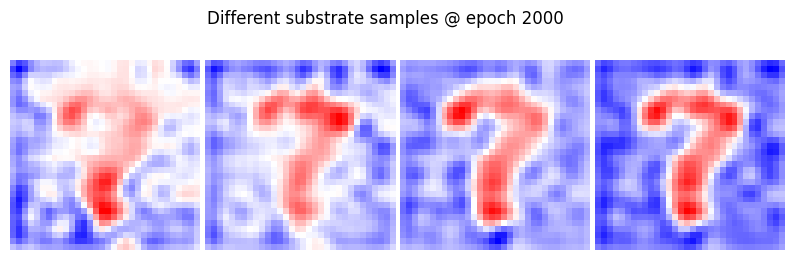

Epoch 2050: train=0.0318, val={'loss': 0.15358354151248932, 'substrate_loss': 0.11868388950824738, 'kl_loss': 0.034899648278951645}
Epoch 2100: train=0.0244, val={'loss': 0.10301131010055542, 'substrate_loss': 0.07774284482002258, 'kl_loss': 0.025268465280532837}
Epoch 2150: train=0.0189, val={'loss': 0.1637926697731018, 'substrate_loss': 0.12586747109889984, 'kl_loss': 0.03792519122362137}
Epoch 2200: train=0.0255, val={'loss': 0.144215390086174, 'substrate_loss': 0.10745131969451904, 'kl_loss': 0.03676406666636467}
torch.Size([50, 1, 32, 32])


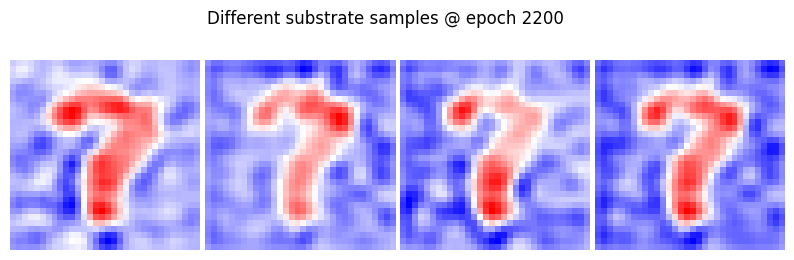

Epoch 2250: train=0.0187, val={'loss': 0.2516228258609772, 'substrate_loss': 0.20808333158493042, 'kl_loss': 0.04353948310017586}
Epoch 2300: train=0.0201, val={'loss': 0.1763560175895691, 'substrate_loss': 0.13760052621364594, 'kl_loss': 0.03875549137592316}
Epoch 2350: train=0.0252, val={'loss': 0.1350034922361374, 'substrate_loss': 0.093100905418396, 'kl_loss': 0.04190259054303169}
Epoch 2400: train=0.0205, val={'loss': 0.13446518778800964, 'substrate_loss': 0.08607923239469528, 'kl_loss': 0.04838595166802406}
torch.Size([50, 1, 32, 32])


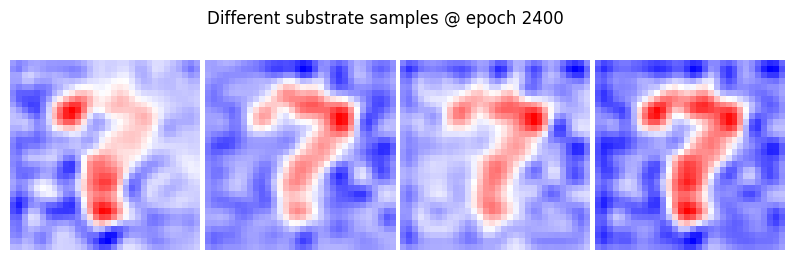

Epoch 2450: train=0.0152, val={'loss': 0.14130952954292297, 'substrate_loss': 0.09234490990638733, 'kl_loss': 0.04896462708711624}
Epoch 2500: train=0.0285, val={'loss': 0.1277899444103241, 'substrate_loss': 0.07575032114982605, 'kl_loss': 0.052039630711078644}
Epoch 2550: train=0.0263, val={'loss': 0.17946308851242065, 'substrate_loss': 0.12832452356815338, 'kl_loss': 0.051138557493686676}
Epoch 2600: train=0.0154, val={'loss': 0.09702922403812408, 'substrate_loss': 0.0466732382774353, 'kl_loss': 0.05035598576068878}
torch.Size([50, 1, 32, 32])


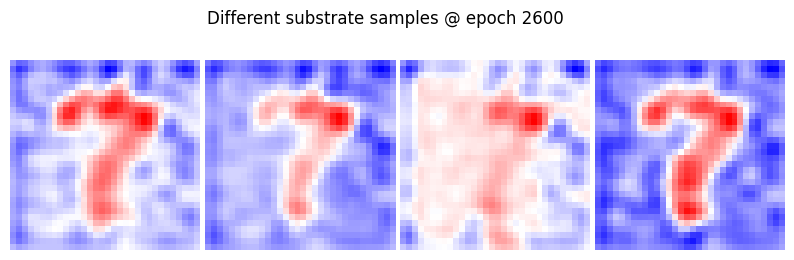

Epoch 2650: train=0.0244, val={'loss': 0.170783132314682, 'substrate_loss': 0.11685171723365784, 'kl_loss': 0.05393140763044357}
Epoch 2700: train=0.0223, val={'loss': 0.1614203304052353, 'substrate_loss': 0.10878945887088776, 'kl_loss': 0.052630867809057236}
Epoch 2750: train=0.0157, val={'loss': 0.13798843324184418, 'substrate_loss': 0.08388499915599823, 'kl_loss': 0.05410343408584595}
Epoch 2800: train=0.0205, val={'loss': 0.20115500688552856, 'substrate_loss': 0.14440035820007324, 'kl_loss': 0.05675465613603592}
torch.Size([50, 1, 32, 32])


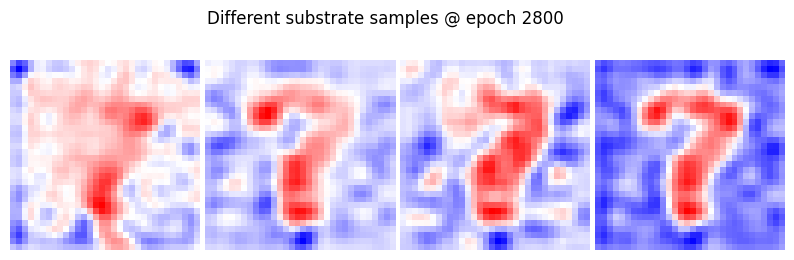

Epoch 2850: train=0.0222, val={'loss': 0.11991190165281296, 'substrate_loss': 0.0619359016418457, 'kl_loss': 0.057976000010967255}
Epoch 2900: train=0.0199, val={'loss': 0.11218009144067764, 'substrate_loss': 0.05303836613893509, 'kl_loss': 0.059141725301742554}
Epoch 2950: train=0.0241, val={'loss': 0.21751104295253754, 'substrate_loss': 0.15735957026481628, 'kl_loss': 0.060151468962430954}

Training done. Best epoch=1416, best val loss=0.0344


In [500]:
EPOCHS = 3000
best_loss = float('inf')
best_epoch = 0

training_losses = []
validation_losses = []

for epoch in range(EPOCHS):
    # -------------------------
    # TRAINING
    # -------------------------
    model.train()
    train_loss_epoch = 0
    ctr = 0

    for x, y in train_loader:
        optimizer.zero_grad()

        # x, y already on GPU by your dataset wrapper
        ret = model(x, y)
        loss = ret['loss']

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss_epoch += loss.item()
        ctr += 1

    training_losses.append(train_loss_epoch / ctr)

    # -------------------------
    # VALIDATION
    # -------------------------
    model.eval()
    val_losses = {k: [] for k in ret if 'loss' in k}
    with torch.no_grad():
        for x, y in val_loader:
            ret = model(x, y)
            for k in val_losses:
                val_losses[k].append(ret[k].item())

    val_loss = np.mean(val_losses['loss'])
    val_losses = {k : np.mean(val_losses[k]) for k in val_losses}
    validation_losses.append(val_losses['loss'])
    scheduler.step()

    # -------------------------
    # LOGGING (every epoch)
    # -------------------------
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: train={training_losses[-1]:.4f}, val={val_losses}")

    # -------------------------
    # SAVE BEST MODEL
    # -------------------------
    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        torch.save(model, "spatial_substrate.pth")
        # Also save EMA model
        # torch.save(ema_model.state_dict(), "diffusion_substrate_best_ema.pth")

    # -------------------------
    # VISUALIZATION (every 20 epochs, matching your style)
    # -------------------------
    if epoch % 200 == 0:
        model.eval()
        with torch.no_grad():
            # Get a batch from validation for conditional sampling
            if model.conditional:
                x_sample, _ = next(iter(val_loader))
                samples = model.sample_substrates(n_samples=x_sample.shape[0], x=x_sample)
            else:
                samples = model.sample_substrates(n_samples=32)
            
            print(samples.shape)
            samples = samples[:, 0, :, :].cpu().numpy()  # [32, H, W]

        # Create visualization matching your style exactly
        fig = plt.figure(figsize=(10, 3))
        grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)
        
        # Show first 3 individual samples
        for i in range(3):
            grid[i].imshow(samples[i], cmap='bwr')
            grid[i].axis('off')
        
        # Show mean of all samples in the 4th panel
        grid[i+1].imshow(np.mean(samples, axis=0), cmap='bwr')
        grid[i+1].axis('off')
        
        plt.suptitle(f"Different substrate samples @ epoch {epoch}")
        plt.show()
        
        model.train()

print(f"\nTraining done. Best epoch={best_epoch}, best val loss={best_loss:.4f}")

In [501]:
model = torch.load("spatial_substrate.pth")
model.conditional = True

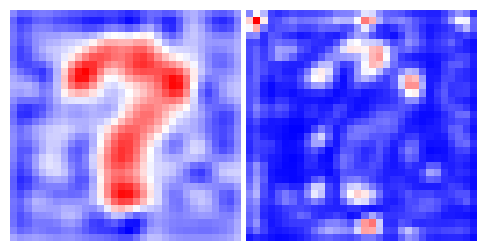

In [502]:
samples = model.sample_substrates(n_samples=128).cpu().numpy()
       
mean = np.mean(samples, axis=0).squeeze(0)
var = np.var(samples, axis=0).squeeze(0)

# Create visualization matching your style exactly
fig = plt.figure(figsize=(10, 3))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.05)


grid[0].imshow(mean, cmap='bwr')
grid[0].axis('off')

# Show mean of all samples in the 4th panel
grid[1].imshow(var, cmap='bwr')
grid[1].axis('off')

# plt.suptitle(f"Different substrate samples @ epoch {epoch}")
plt.show()

In [503]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from tqdm import tqdm


def find_optimal_threshold(model, train_loader, val_loader, device='cuda', n_substrate_samples=128):
    """
    Find optimal threshold for binarizing the substrate based on validation performance.
    
    Args:
        model: trained SpatialSubstrate model
        train_loader: training dataloader (for conditional substrate generation)
        val_loader: validation dataloader (for threshold optimization)
        device: device to run on
        n_substrate_samples: number of substrate samples to average over (unconditional only)
        
    Returns:
        dict with threshold info and substrate statistics
    """
    model.eval()
    
    with torch.no_grad():
        if not model.conditional:
            # Unconditional: sample once from prior
            print(f"Sampling {n_substrate_samples} substrates from prior...")
            substrates = model.sample_substrates(n_samples=n_substrate_samples, x=None)  # [n_samples, C, H, W]
            mean_substrate = substrates.mean(dim=0)  # [C, H, W]
            substrate_samples = substrates.cpu()
            
            # Use same mean substrate for all validation samples
            print("Evaluating on validation set...")
            all_predictions = []
            all_labels = []
            
            for x, y in tqdm(train_loader):
                x, y = x.to(device), y.to(device)
                B = x.shape[0]
                
                substrate_logits = mean_substrate.unsqueeze(0).expand(B, -1, -1, -1).to(device)
                
                # Compute predictions
                overlap = x * substrate_logits
                logits = torch.mean(overlap, dim=(-3, -2, -1)).view(-1, 1)
                probs = torch.sigmoid(logits)
                
                all_predictions.append(probs.cpu())
                all_labels.append(y.cpu())
            
            mean_substrate = mean_substrate.cpu().numpy()
        
        else:
            # Conditional: generate substrates on TRAINING set to get mean substrate
            print("Generating conditional substrates on training set...")
            all_substrates = []
            
            for x, y in tqdm(train_loader, desc="Generating substrates from train"):
                x = x.to(device)
                
                # Sample one substrate per x (using base + delta)
                # substrate_logits = model.sample_substrates(n_samples=None, x=x)  # [B, C, H, W]
                substrate_logits = model.sample_substrates_with_guidance(x, guidance_scale=1)
                all_substrates.append(substrate_logits.cpu())
            
            # Compute mean substrate from training set
            substrate_samples = torch.cat(all_substrates)  # [N_train, C, H, W]
            mean_substrate = substrate_samples.mean(dim=0)  # [C, H, W]
            std_substrate = substrate_samples.std(dim=0)
            
            # Now evaluate on VALIDATION set using the mean substrate from training
            print("Evaluating on validation set with mean substrate from training...")
            all_predictions = []
            all_labels = []
            
            for x, y in tqdm(train_loader, desc="Training"):
                x, y = x.to(device), y.to(device)
                B = x.shape[0]
                
                # Use mean substrate for all
                substrate_logits = mean_substrate.unsqueeze(0).expand(B, -1, -1, -1).to(device)
                
                # Compute predictions
                overlap = x * substrate_logits
                logits = torch.mean(overlap, dim=(-3, -2, -1)).view(-1, 1)
                probs = torch.sigmoid(logits)
                
                all_predictions.append(probs.cpu())
                all_labels.append(y.cpu())
            
#             for x, y in tqdm(val_loader, desc="Validation"):
#                 x, y = x.to(device), y.to(device)
#                 B = x.shape[0]
                
#                 # Use mean substrate for all
#                 substrate_logits = mean_substrate.unsqueeze(0).expand(B, -1, -1, -1).to(device)
                
#                 # Compute predictions
#                 overlap = x * substrate_logits
#                 logits = torch.mean(overlap, dim=(-3, -2, -1)).view(-1, 1)
#                 probs = torch.sigmoid(logits)
                
#                 all_predictions.append(probs.cpu())
#                 all_labels.append(y.cpu())
            
            mean_substrate = mean_substrate.cpu().numpy()
    
    all_predictions = torch.cat(all_predictions).numpy().flatten()
    all_labels = torch.cat(all_labels).numpy().flatten()
    
    # Compute statistics
    std_substrate = substrate_samples.std(dim=0).cpu().numpy()
    
    # Find optimal threshold using multiple criteria
    print("Finding optimal thresholds on validation set...")
    
    # 1. ROC-based threshold (Youden's J statistic)
    fpr, tpr, roc_thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)
    j_scores = tpr - fpr
    best_roc_idx = np.argmax(j_scores)
    optimal_threshold_roc = roc_thresholds[best_roc_idx]
    
    # 2. Precision-Recall based threshold (F1 score)
    precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_predictions)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
    best_f1_idx = np.argmax(f1_scores)
    optimal_threshold_f1 = pr_thresholds[best_f1_idx]
    
    # 3. Substrate intensity threshold (for visualization)
    substrate_flat = mean_substrate.flatten()
    substrate_abs = np.abs(substrate_flat)
    
    percentiles = [50, 75, 90, 95, 99]
    intensity_thresholds = {
        f'p{p}': np.percentile(substrate_abs, p) for p in percentiles
    }
    
    results = {
        'mean_substrate': mean_substrate,
        'std_substrate': std_substrate,
        'substrate_samples': substrate_samples,
        'conditional': model.conditional,
        
        'optimal_threshold_roc': optimal_threshold_roc,
        'optimal_threshold_f1': optimal_threshold_f1,
        
        'roc_auc': roc_auc,
        'best_tpr': tpr[best_roc_idx],
        'best_fpr': fpr[best_roc_idx],
        'best_f1': f1_scores[best_f1_idx],
        'best_precision': precision[best_f1_idx],
        'best_recall': recall[best_f1_idx],
        
        'roc_curve': (fpr, tpr, roc_thresholds),
        'pr_curve': (precision, recall, pr_thresholds),
        
        'intensity_thresholds': intensity_thresholds,
        
        'predictions': all_predictions,
        'labels': all_labels,
    }
    
    return results


ret_dict = find_optimal_threshold(model, train_loader, val_loader, n_substrate_samples=512)

Generating conditional substrates on training set...


Generating substrates from train: 100%|██████████| 15/15 [00:00<00:00, 528.19it/s]


Evaluating on validation set with mean substrate from training...


Training: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s]


Finding optimal thresholds on validation set...


In [504]:
for k in ret_dict:
    if 'best' in k:
        print(k, ret_dict[k])

best_tpr 0.9857954545454546
best_fpr 0.010948905109489052
best_f1 0.9843971581205776
best_precision 0.9830028328611898
best_recall 0.9857954545454546


In [505]:
vae_mask = ret_dict['mean_substrate'].squeeze(0)

vae_mask.shape

(32, 32)

In [506]:
# RUN SVR-LSM APPROXIMATION FOR DEBUGGING PURPOSES
from sklearn import svm

# We're doing binary classification
continuous = False

svm_data = np.reshape(train_data, [train_data.shape[0], train_data.shape[2]**2])

svr_labels = train_labels
if continuous:
    svr_labels = (train_labels - train_labels.mean())
    svr_labels = svr_labels / svr_labels.std()
svm_data = svm_data / (np.linalg.norm(svm_data, axis=-1, keepdims=True) + 1e-5)

if continuous:
    svm = svm.SVR(kernel='rbf', C=0.8)
else:
    svm = svm.SVC(kernel='rbf')
svm.fit(svm_data, svr_labels)

alphas = svm.dual_coef_

backprojection = alphas * np.transpose(svm.support_vectors_)
backprojection = np.sum(backprojection, axis=1)
svm_preds = np.reshape(backprojection, [train_data.shape[2], train_data.shape[2]])
svm_preds.shape

(32, 32)

In [507]:
# RUN VLSM APPROXIMATION FOR DEBUGGING PURPOSES

idxs_p = np.where(train_labels > 0)
idxs_n = np.where(train_labels == 0)
img_size = 32

fisher_preds = np.zeros((img_size, img_size))
for i in range(img_size):
    for j in range(img_size):
        index_vox = train_data[:, 0, i, j]

        table = np.zeros((2, 2))
        table[0, 0] = np.sum(index_vox[idxs_n] == 0)
        table[0, 1] = np.sum(index_vox[idxs_n] > 0)
        table[1, 0] = np.sum(index_vox[idxs_p] == 0)
        table[1, 1] = np.sum(index_vox[idxs_p] > 0)

        p_value = scipy.stats.fisher_exact(table, 'greater')[-1]
        fisher_preds[i, j] = p_value

fisher_preds = - np.log(fisher_preds)
univar_preds = fisher_preds

In [508]:
def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool_)
    im2 = np.asarray(im2).astype(np.bool_)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [509]:
# best_threshold = ret_dict["optimal_threshold_f1"]
best_threshold = ret_dict["optimal_threshold_roc"]

In [510]:
vae_mask.shape

(32, 32)

In [511]:

'''
THIS IS JUST FOR DEBUGGING PURPOSES
FOR PROPER EVALUATION YOU'LL HAVE TO GET P-VALUES FOR VLSM AND SVR-LSM 
AND THEN USE FWER/FDR
'''

results = {'VDVAE-LDM': vae_mask, 'VLSM': univar_preds, 'SVR-LSM': svm_preds}

keys = ['VDVAE-LDM', 'VLSM', 'SVR-LSM']
thresholds = {}
for k in keys:
    thresholds[k] = {'dice': [0, 0], 'hausdorff': [1e10, 0], 'asd': [1e10, 0],
                    }

for k in results:
    results[k] = results[k] - results[k].min()
    results[k] = results[k] / (results[k].max())

threshold_range = np.linspace(0.8, 0.99, num=20)
# threshold_range = [0.9]
thresholded_masks = {'VDVAE-LDM': vae_mask, 'VLSM': univar_preds, 'SVR-LSM': svm_preds}
for thresh in threshold_range:
    for k in thresholds:
        if k == 'VDVAE-LDM':
            t = best_threshold
        else:
            t = np.quantile(results[k], thresh)
        bin_res = results[k] > t

        preds = np.expand_dims(np.expand_dims(results[k], axis=0), axis=0)
        bin_preds = np.expand_dims(np.expand_dims(bin_res, axis=0), axis=0)
        monai_gt = np.expand_dims(np.expand_dims(substrate, axis=0), axis=0)
        
        dice_s = dice(bin_res, substrate)
            
        if dice_s > thresholds[k]['dice'][0]:
            thresholded_masks[k] = bin_res
            thresholds[k]['dice'][0] = round(dice_s, 2)
            if k == 'VDVAE-LDM':
                thresholds[k]['dice'][1] = best_threshold
            else:
                thresholds[k]['dice'][1] = thresh
            
            
            
            
thresholds

{'VDVAE-LDM': {'dice': [0.87, 0.5106569],
  'hausdorff': [10000000000.0, 0],
  'asd': [10000000000.0, 0]},
 'VLSM': {'dice': [0.78, 0.8],
  'hausdorff': [10000000000.0, 0],
  'asd': [10000000000.0, 0]},
 'SVR-LSM': {'dice': [0.87, 0.8200000000000001],
  'hausdorff': [10000000000.0, 0],
  'asd': [10000000000.0, 0]}}

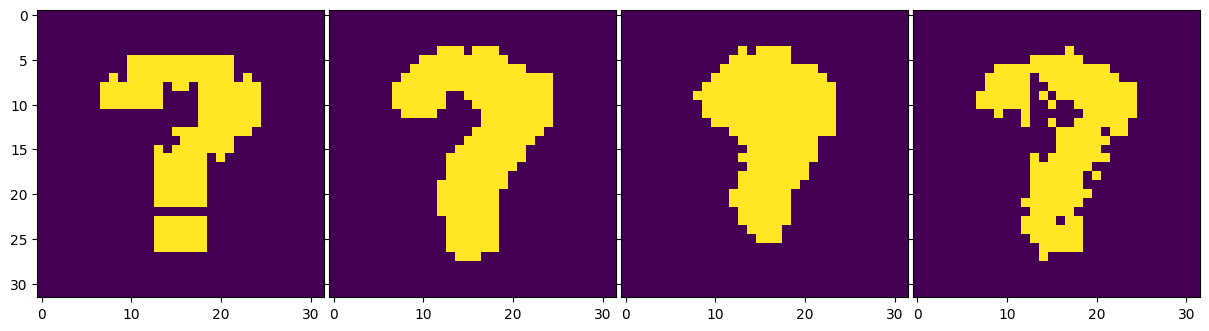

In [512]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(1, 4),
                 axes_pad=0.05,
                 share_all=True
                 )

grid[0].imshow(substrate)
grid[1].imshow(thresholded_masks['VDVAE-LDM'])
grid[2].imshow(thresholded_masks['VLSM'])
grid[3].imshow(thresholded_masks['SVR-LSM'])